# **THESEUS**
## **INFERENCE**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# **CONFIGURATION**

In [2]:

CONFIG_LIBRARY={

    1 :  {    "id": 1,
    "type":"LGBMClassifier",
    "parent": 0, # 0 means metamodel
    "children": None, 
    "parameters" : {},
    "make_data_func": "make_data_for_lgb",
    "fit_func": "kfold_lgb"
    
    
},
    
    2: {
    "id": 2,
    "type":"CatBoost",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_lgb",
    "fit_func": "kfold_cat"
}
,
    0: {
    "id": 0,
    "type" : "Ensemble (LGBMClassifier, CatBoost)",
    "parent": None,
    "children" : [1,2],
    "parameters" : {},
    "make_data_func": None,
    "fit_func": None
    
},
    
    
    
}
    


# **INFRASTRUCTURE**

In [3]:
class VotingModel():
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        
        return np.mean(y_preds, axis=0)

In [4]:
class Model:
    def __init__ (self, init_id):
        
        if init_id==0:
            print("MODEL ", init_id, " is being initialized")
        else:
            print("\tMODEL ", init_id, " is being initialized")
        if init_id not in CONFIG_LIBRARY:
            raise ValueError("Invalid input Type - class Model initialization")
        
          
        self.definition=CONFIG_LIBRARY[init_id]    

        self.state=0 
        # 0=initialized
        # 1,  for base models: fitted; for ensembles: created oof predictions
       
        self.id=init_id
        self.model_children=[]
        
        if self.definition['children'] is not None:
            print("model ", init_id, " has children ",self.definition['children'])
            for i in self.definition['children']:
             
                if i not in CONFIG_LIBRARY:
                    raise ValueError("Invalid input Type - class Model initialization")
                
                self.model_children.append(Model(i))
                
        if init_id==0:
            print("MODEL ", init_id, " has been initialized")      
        else:
            print("\tMODEL ", init_id, " has been initialized")     
       
            
    def make_data(self):
        print("Function make_data of model ", self.id, " has started")
        func = globals().get(self.definition["make_data_func"])
        if func is not None and callable(func):
            
            path=func()
        else:
            raise ValueError("Invalid input Type - make data function")
            
        
            
        return path
    
    
    def fit(self, path):
        
        print("Fit - model ", self.id, " started, path: ", path)
        func = globals().get(self.definition["fit_func"])
        if func is not None and callable(func):
            self.estimators=[]
            #self.estimators
            self.model, self.oof_preds=func(path)
        else:
            raise ValueError("Invalid input Type - fit function") 
       
        print("Fit - model ", self.id, " finished")
        
        
        
        
        '''
    def predict(self):
        
    def predict_proba(self):
        
    def set_oof_predictions(self, series):
        
    def get_oof_predictions(self, series):
        
    def stack(self):
    '''
    


In [5]:
def initialization():
    
    print("Function initialization has been started")
    if not check_validity():
        raise ValueError("Invalid input Type - model configuration")
    metamodel=Model(0)
    print("Function initialization has been successful")
    print()
 
    return metamodel

In [6]:
def kfold_lgb(path):
    
    data=pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    for col in data.columns:
        print(col, data[col].dtype)
        
        
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42)
    fitted_models=[]
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            clf = LGBMClassifier()  # Create LGBMClassifier model
            clf.fit(train_data.drop('target', axis=1), train_data['target'])  # Fit the model
            fitted_models.append(clf)
            oof_preds[valid_idx]=clf.predict_proba(valid_data.drop('target', axis=1))[:,1]
            # Append the model to the list of fitted models
            pbar.update(1)
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    model=VotingModel(fitted_models)
    return model, pd.Series(oof_preds, index=data['case_id'])

In [7]:
def kfold_cat(path):
    data = pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    
    for col in data.columns:
        print(col, data[col].dtype)
        
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fitted_models = []
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            
            clf = CatBoostClassifier(iterations=1000,  # Specify the number of iterations
                                     learning_rate=0.1,  # Specify the learning rate
                                     depth=6,  # Specify the depth of the trees
                                     loss_function='Logloss',  # Specify the loss function
                                     verbose=100)  # Set verbose to print training progress
                                     
            clf.fit(train_data.drop(columns=['target', 'case_id'], axis=1),  # Train the model
                    train_data['target'],
                    eval_set=(valid_data.drop(columns=['target','case_id'], axis=1), valid_data['target']),
                    verbose_eval=100)  # Set verbose to print evaluation progress
            
            fitted_models.append(clf)
            oof_preds[valid_idx] = clf.predict_proba(valid_data.drop(columns=['target','case_id'], axis=1))[:, 1]
            pbar.update(1)
    
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    
    model = VotingModel(fitted_models)  # Assuming VotingModel is defined elsewhere
    return model, pd.Series(oof_preds, index=data['case_id'])

In [8]:
def make_data_for_lgb():
    print("make_data_for_lgb started")
    # Load the Titanic dataset
    titanic_df = sns.load_dataset('titanic')

    titanic_df = pd.get_dummies(titanic_df, columns=['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone'])
    titanic_df.drop(columns=['alive'], inplace=True)
    # Fill NaN values
    titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values

    titanic_df.rename(columns={'survived': 'target'}, inplace=True)
    
    # Add "case_id" column for every row
    titanic_df = titanic_df.assign(case_id=np.arange(len(titanic_df)))
    
    # Randomly select 10% of rows and set their "target" values to NaN
    n_rows = titanic_df.shape[0]
    n_nan_rows = int(0.1 * n_rows)  # 10% of rows
    nan_indices = np.random.choice(titanic_df.index, size=n_nan_rows, replace=False)
    titanic_df.loc[nan_indices, 'target'] = np.nan
    
    # Display the first few rows of the dataset
    #print(titanic_df.head())

    titanic_df.dtypes.value_counts()
    
    path = "/kaggle/working/lgb_data.parquet"
    # Export DataFrame to Parquet
    
    
    
    
    
    titanic_df.to_parquet(path)
    
    print("shape: ", titanic_df.shape)
    for col in titanic_df.columns:
        print("\t\t\t", col)
    print("make_data_for_lgb finished")
    return path

In [9]:
def check_validity():
    
    if not(all(isinstance(key, int) for key in CONFIG_LIBRARY.keys()) and \
       len(CONFIG_LIBRARY.keys()) == len(set(CONFIG_LIBRARY.keys())) and \
       all(isinstance(value, dict) for value in CONFIG_LIBRARY.values())):
        # Your code here if all conditions are met
  
        return False
    
    
    required_keys = {
    "id", "type", "parent", "children", "parameters", "make_data_func", "fit_func"
}
    

    
    for library in CONFIG_LIBRARY.values():
        if not required_keys.issubset(library.keys()):
        
            return False
        
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["type"], str):
            #print("The value associated with the key 'id' is an integer.")
        
            print("The value associated with the key 'type' is either missing or not an integer.")
            return False
        

    
    
    return True

In [10]:
def fit_models(meta):
    
    print("Function fit_models has been started")
    
    
    if meta.model_children is None:
        print("Training of model ", child.id, " has started")
        path=meta.make_data()
        meta.fit(path)
        print("Training of model ", child.id, " has been successful")
        print()
    
    for child in meta.model_children:
        
        #print(base_model.definition)
        # iteration to get to the base model
        print("Training of model ", child.id, " has started")
        #print(children.definition["make_data_func"])
        path=child.make_data()
        child.fit(path)
        print("Training of model ", child.id, " has been successful")
        print()
    
    # iterate through children
    
    
    
    
  

In [11]:
def main(debug=False):
    
    metamodel=initialization()
    # Creates dummy version of the models.
    
    metamodel=fit_models(metamodel)
    # It trains models, it goes from apex down to the base models.
    # It creates oof predictions.
    
    #metamodel=ensemble_models(metamodel)
    
    #It sets the blending technique/
    # Now, predict_proba in metamodel is ready to be called.
    
    
    

/tmp/ipykernel_277/2711016437.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


Function initialization has been started
MODEL  0  is being initialized
model  0  has children  [1, 2]
	MODEL  1  is being initialized
	MODEL  1  has been initialized
	MODEL  2  is being initialized
	MODEL  2  has been initialized
MODEL  0  has been initialized
Function initialization has been successful

Function fit_models has been started
Training of model  1  has started
Function make_data of model  1  has started
make_data_for_lgb started
shape:  (891, 31)
			 target
			 pclass
			 age
			 sibsp
			 parch
			 fare
			 adult_male
			 sex_female
			 sex_male
			 embarked_C
			 embarked_Q
			 embarked_S
			 class_First
			 class_Second
			 class_Third
			 who_child
			 who_man
			 who_woman
			 deck_A
			 deck_B
			 deck_C
			 deck_D
			 deck_E
			 deck_F
			 deck_G
			 embark_town_Cherbourg
			 embark_town_Queenstown
			 embark_town_Southampton
			 alone_False
			 alone_True
			 case_id
make_data_for_lgb finished
Fit - model  1  started, path:  /kaggle/working/lgb_data.parquet
bool 

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 243, number of negative: 398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.379095 -> initscore=-0.493391
[LightGBM] [Info] Start training from score -0.493391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 20%|██        | 1/5 [00:00<00:01,  2.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 243, number of negative: 398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.379095 -> initscore=-0.493391
[LightGBM] [Info] Start training from score -0.493391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

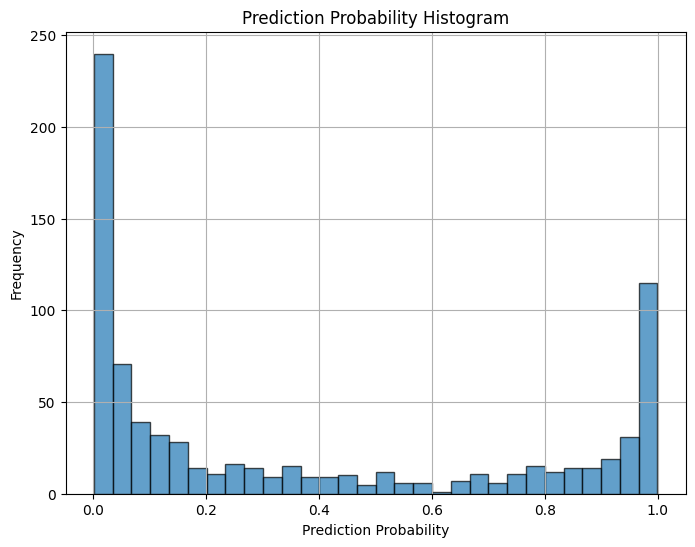

/tmp/ipykernel_277/2711016437.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


Fit - model  1  finished
Training of model  1  has been successful

Training of model  2  has started
Function make_data of model  2  has started
make_data_for_lgb started
shape:  (891, 31)
			 target
			 pclass
			 age
			 sibsp
			 parch
			 fare
			 adult_male
			 sex_female
			 sex_male
			 embarked_C
			 embarked_Q
			 embarked_S
			 class_First
			 class_Second
			 class_Third
			 who_child
			 who_man
			 who_woman
			 deck_A
			 deck_B
			 deck_C
			 deck_D
			 deck_E
			 deck_F
			 deck_G
			 embark_town_Cherbourg
			 embark_town_Queenstown
			 embark_town_Southampton
			 alone_False
			 alone_True
			 case_id
make_data_for_lgb finished
Fit - model  2  started, path:  /kaggle/working/lgb_data.parquet
bool       24
int64       4
float64     3
Name: count, dtype: int64
target float64
pclass int64
age float64
sibsp int64
parch int64
fare float64
adult_male bool
sex_female bool
sex_male bool
embarked_C bool
embarked_Q bool
embarked_S bool
class_First bool
class_Second bool
class_T

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6302405	test: 0.6279365	best: 0.6279365 (0)	total: 49.3ms	remaining: 49.3s
100:	learn: 0.2465012	test: 0.4227860	best: 0.3928799 (27)	total: 206ms	remaining: 1.83s
200:	learn: 0.1690979	test: 0.4492530	best: 0.3928799 (27)	total: 375ms	remaining: 1.49s
300:	learn: 0.1157719	test: 0.4837853	best: 0.3928799 (27)	total: 529ms	remaining: 1.23s
400:	learn: 0.0883946	test: 0.5114299	best: 0.3928799 (27)	total: 700ms	remaining: 1.04s
500:	learn: 0.0694971	test: 0.5379104	best: 0.3928799 (27)	total: 895ms	remaining: 892ms
600:	learn: 0.0585797	test: 0.5609870	best: 0.3928799 (27)	total: 1.08s	remaining: 719ms
700:	learn: 0.0502511	test: 0.5752712	best: 0.3928799 (27)	total: 1.27s	remaining: 542ms
800:	learn: 0.0449118	test: 0.5913291	best: 0.3928799 (27)	total: 1.46s	remaining: 362ms
900:	learn: 0.0398675	test: 0.6106930	best: 0.3928799 (27)	total: 1.65s	remaining: 181ms


 20%|██        | 1/5 [00:02<00:08,  2.02s/it]

999:	learn: 0.0366571	test: 0.6241412	best: 0.3928799 (27)	total: 1.84s	remaining: 0us

bestTest = 0.3928799309
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 0.6311826	test: 0.6386978	best: 0.6386978 (0)	total: 1.89ms	remaining: 1.89s
100:	learn: 0.2269978	test: 0.4302675	best: 0.4241598 (79)	total: 173ms	remaining: 1.54s
200:	learn: 0.1446722	test: 0.4615901	best: 0.4241598 (79)	total: 331ms	remaining: 1.31s
300:	learn: 0.1051449	test: 0.5014898	best: 0.4241598 (79)	total: 501ms	remaining: 1.16s
400:	learn: 0.0814135	test: 0.5276237	best: 0.4241598 (79)	total: 701ms	remaining: 1.05s
500:	learn: 0.0650345	test: 0.5567745	best: 0.4241598 (79)	total: 861ms	remaining: 857ms
600:	learn: 0.0549049	test: 0.5817987	best: 0.4241598 (79)	total: 1.03s	remaining: 684ms
700:	learn: 0.0479903	test: 0.6013034	best: 0.4241598 (79)	total: 1.22s	remaining: 520ms
800:	learn: 0.0425386	test: 0.6203107	best: 0.4241598 (79)	total: 1.39s	remaining: 344ms
900:	learn: 0.0387044	test: 0.64

 40%|████      | 2/5 [00:03<00:05,  1.98s/it]


bestTest = 0.4241598182
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 0.6337306	test: 0.6355387	best: 0.6355387 (0)	total: 1.95ms	remaining: 1.94s
100:	learn: 0.2445877	test: 0.4175391	best: 0.3990200 (55)	total: 180ms	remaining: 1.6s
200:	learn: 0.1535316	test: 0.4452888	best: 0.3990200 (55)	total: 373ms	remaining: 1.48s
300:	learn: 0.1083086	test: 0.4668777	best: 0.3990200 (55)	total: 534ms	remaining: 1.24s
400:	learn: 0.0850234	test: 0.4859329	best: 0.3990200 (55)	total: 719ms	remaining: 1.07s
500:	learn: 0.0662213	test: 0.5077148	best: 0.3990200 (55)	total: 909ms	remaining: 905ms
600:	learn: 0.0560371	test: 0.5238796	best: 0.3990200 (55)	total: 1.06s	remaining: 706ms
700:	learn: 0.0475746	test: 0.5425217	best: 0.3990200 (55)	total: 1.25s	remaining: 531ms
800:	learn: 0.0421828	test: 0.5558346	best: 0.3990200 (55)	total: 1.43s	remaining: 355ms
900:	learn: 0.0388247	test: 0.5740625	best: 0.3990200 (55)	total: 1.62s	remaining: 179ms


 60%|██████    | 3/5 [00:05<00:03,  1.99s/it]

999:	learn: 0.0355866	test: 0.5872446	best: 0.3990200 (55)	total: 1.83s	remaining: 0us

bestTest = 0.3990199737
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 0.6272105	test: 0.6401039	best: 0.6401039 (0)	total: 2.86ms	remaining: 2.86s
100:	learn: 0.2195274	test: 0.4881406	best: 0.4748428 (34)	total: 185ms	remaining: 1.65s
200:	learn: 0.1401887	test: 0.5476140	best: 0.4748428 (34)	total: 362ms	remaining: 1.44s
300:	learn: 0.0951049	test: 0.5991644	best: 0.4748428 (34)	total: 546ms	remaining: 1.27s
400:	learn: 0.0723898	test: 0.6432199	best: 0.4748428 (34)	total: 725ms	remaining: 1.08s
500:	learn: 0.0577815	test: 0.6797442	best: 0.4748428 (34)	total: 912ms	remaining: 908ms
600:	learn: 0.0494227	test: 0.7195796	best: 0.4748428 (34)	total: 1.1s	remaining: 731ms
700:	learn: 0.0430977	test: 0.7410832	best: 0.4748428 (34)	total: 1.29s	remaining: 550ms
800:	learn: 0.0388229	test: 0.7621284	best: 0.4748428 (34)	total: 1.48s	remaining: 368ms
900:	learn: 0.0358221	test: 0.776

 80%|████████  | 4/5 [00:07<00:01,  1.98s/it]

999:	learn: 0.0336804	test: 0.7974747	best: 0.4748428 (34)	total: 1.79s	remaining: 0us

bestTest = 0.4748427646
bestIteration = 34

Shrink model to first 35 iterations.
0:	learn: 0.6362052	test: 0.6322130	best: 0.6322130 (0)	total: 2ms	remaining: 2s
100:	learn: 0.2507917	test: 0.3758875	best: 0.3633303 (44)	total: 182ms	remaining: 1.62s
200:	learn: 0.1575131	test: 0.3996080	best: 0.3633303 (44)	total: 352ms	remaining: 1.4s
300:	learn: 0.1142924	test: 0.4226567	best: 0.3633303 (44)	total: 548ms	remaining: 1.27s
400:	learn: 0.0879447	test: 0.4486097	best: 0.3633303 (44)	total: 743ms	remaining: 1.11s
500:	learn: 0.0707373	test: 0.4763649	best: 0.3633303 (44)	total: 932ms	remaining: 928ms
600:	learn: 0.0595615	test: 0.5049390	best: 0.3633303 (44)	total: 1.14s	remaining: 754ms
700:	learn: 0.0532366	test: 0.5165717	best: 0.3633303 (44)	total: 1.33s	remaining: 567ms
800:	learn: 0.0482566	test: 0.5303591	best: 0.3633303 (44)	total: 1.52s	remaining: 378ms
900:	learn: 0.0442066	test: 0.5456934	b

100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


Full AUC score 0.867347
Confusion Matrix for Full Dataset:
[[446  50]
 [ 97 209]]


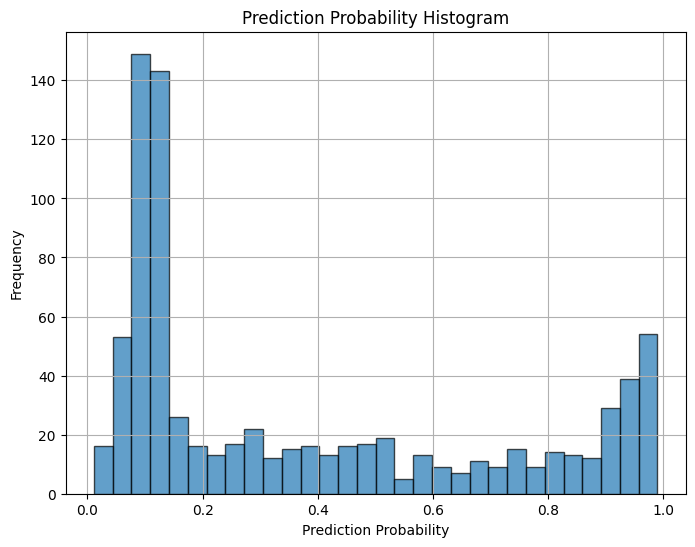

Fit - model  2  finished
Training of model  2  has been successful



In [12]:
main()